In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
import scipy as sci
from scipy import constants
from scipy.interpolate import CubicSpline
from scipy.interpolate import PchipInterpolator
from scipy.interpolate import Akima1DInterpolator
from scipy.interpolate import interp1d
import pandas as pd
import csv
import math
from random import randint
from numpy import linspace, zeros
from matplotlib.ticker import MultipleLocator

In [2]:
G = constants.G
c = constants.c
pi = constants.pi
print(pi, G, c)

3.141592653589793 6.6743e-11 299792458.0


In [3]:
#now, we'll try to use the SSM BP 2005 eos data to produce a Solar Star using TOV equations,
SSM_arr = np.loadtxt('/home/pullu/Desktop/TZO/EoS_data/SSM_BS2005-AGS_OP.txt', dtype = "str", delimiter = ',')
M = np.zeros(len(SSM_arr))
R = np.zeros(len(SSM_arr))
T = np.zeros(len(SSM_arr))
rho = np.zeros(len(SSM_arr))
P = np.zeros(len(SSM_arr))
L = np.zeros(len(SSM_arr))
X = np.zeros(len(SSM_arr))
Y_He4 = np.zeros(len(SSM_arr))
He3 = np.zeros(len(SSM_arr))
C12 = np.zeros(len(SSM_arr))
N14 = np.zeros(len(SSM_arr))
O16 = np.zeros(len(SSM_arr))
for idx in range(len(SSM_arr)):
    input_string = SSM_arr[idx]
    str_values = input_string.split()
    float_values = [float(value) for value in str_values]
    #print(float_values)
    #eos_arr[i] = float_values
    M[idx], R[idx], T[idx], rho[idx], P[idx], L[idx], X[idx], Y_He4[idx], He3[idx], C12[idx], N14[idx], O16[idx] = float_values
    #print(M[idx], R[idx], T[idx], rho[idx], P[idx], L[idx], X[idx], Y_He4[idx], He3[idx], C12[idx], N14[idx], O16[idx])
print(len(SSM_arr))
print("ok")

1284
ok


In [4]:
#converting to SI units
P = 0.1*P
rho = 1000*rho
counter = 0
# for idx in range(len(SSM_arr)):
#     print(idx, "," , rho[idx], "," , P[idx])

In [5]:
#sorting the arrays in ascending order of density
#First sort these arrays such as rho becomes strictly increasing sequence
# Sort x and y based on the values of x (P and rho based on rho)
sorted_indices_rho = np.argsort(rho)
rho_sorted_rho = rho[sorted_indices_rho]
P_sorted_rho = P[sorted_indices_rho]
counter_rho = 0
for idx in range(len(rho)-1):
    #print(idx, "," , rho_sorted_rho[idx], ",", P_sorted_rho[idx])
    if(rho_sorted_rho[idx+1] <= rho_sorted_rho[idx]):
        #print(idx, "******************************* ", rho[idx+1])
        counter_rho = counter_rho + 1
print(counter_rho)
print(len(rho))

366
1284


In [6]:
#update equation of state sequence
#ignore all the points which are very close
#find the minimum first - already sorted
#next entry should be atleast 0.1% greater than the minimum one
rho_new = []
P_new = []
counter = 0
for i in range(len(rho_sorted_rho)):
    if(i == 0):
        rho_new.append(rho_sorted_rho[i])
        P_new.append(P_sorted_rho[i])
        #print(rho_new[i])
    elif(rho_sorted_rho[i] >= 1.0001*rho_sorted_rho[i-1]):
        rho_new.append(rho_sorted_rho[i])
        P_new.append(P_sorted_rho[i])
        counter = counter + 1
        #print(i , " " , rho_sorted_rho[i], " ", rho_new[i])
#print(rho_new)
print(counter)
print(len(rho_sorted_rho))
print(len(rho_new))
print(len(P_new))
# for i in range(len(rho_new)):
#     print(i, " ", rho_new[i], " ", P_new[i])

917
1284
918
918


In [7]:
#Interpolation Code, for P
# three arguments : P  and e are the arrays and temp is the value of density for which the pressure has to be found
def interpolate_P(temp, P, e):
    Pr = 0
    for idx in range(len(P)-1):
        #print(temp, " , ", e[idx])
        if (temp == e[idx]):
            Pr = P[idx]
            #print(Pr)
        elif(e[idx + 1] >= temp >= e[idx]):
            Pr = P[idx] + (temp-e[idx])*(P[idx + 1] - P[idx])/(e[idx + 1] - e[idx])
            #print(Pr)
#         else:
#             Pr = 0
#             print("Error, could not interpolate pressure")
#             break
    return Pr

def interpolate_e(temp, P, e):
    er = 0
    for idx in range(len(P)-1):
        #print(temp, " , ", P[idx])
        if(temp == P[idx]):
            #print('yes')
            er = e[idx]
            #print(er)
            break
        elif(P[idx + 1] >= temp >= P[idx]):
            #print('yes')
            er = e[idx] + (temp-P[idx])*(e[idx + 1] - e[idx])/(P[idx + 1] - P[idx])
            #print(er)
#         else:
#             er = 0
#             print("Error, could not interpolate density")
            break
    return er

In [8]:
print(len(rho))
#interpolation function check
epsi = 150000 #SI units
Pi = interpolate_P(epsi,P_new, rho_new)
print(Pi)
print(interpolate_e(Pi, P_new, rho_new))

1284
2.332e+16
150000.0


In [9]:
#checking interpolation code
rho_interpolated = np.zeros(len(rho))
P_interpolated = np.zeros(len(rho))
#for any one step at first
idx = randint(0,len(rho)-1)
rhom = (rho_sorted_rho[idx] + rho_sorted_rho[idx + 1])/2
Pm = interpolate_P(rhom,P_sorted_rho,rho_sorted_rho)
print(rho_sorted_rho[idx],rhom,rho_sorted_rho[idx + 1])
print(P_sorted_rho[idx], Pm, P_sorted_rho[idx + 1])
#now, for the entire eos table
for i in range(len(rho)-1):
    rho_interpolated[i] = (rho_sorted_rho[i] + rho_sorted_rho[i + 1])/2
    P_interpolated[i] = interpolate_P(rho_interpolated[i],P_sorted_rho,rho_sorted_rho)
    #print(P_interpolated[i])

70050.0 70315.0 70580.0
1.055e+16 1.06e+16 1.065e+16


In [10]:
def RK4_step(dy_dr, dz_dr, yi, zi, r, h, args):
    
    K1 = dy_dr(r, yi,  zi, args)
    L1 = dz_dr(r, yi , zi, args)
    #print("K1 and L1 done", K1, L1)
    #print(K1, L1)
    K2 = dy_dr(r + h/2, yi + h*K1/2, zi + h*L1/2, args)
    L2 = dz_dr(r + h/2, yi + h*K1/2, zi + h*L1/2, args)
    #print("K2 and L2 are done",K2, L2)
    #print("here is the der. ", dz_dr(r + h/2, yi + h*K1/2, zi + h*L1/2))
    K3 = dy_dr(r + h/2, yi + h*K2/2, zi + h*L2/2, args)
    L3 = dz_dr(r + h/2, yi + h*K2/2, zi + h*L2/2, args)
    #print("K3 and L3 are done", K3, L3)
    #print(dz_dr(r + h/2, yi + h*K2/2, zi + h*L2/2))
    K4 = dy_dr(r + h, yi + h*K3, zi + h*L3, args)
    L4 = dz_dr(r + h, yi + h*K3, zi + h*L3, args)
    #print("K4 and L4 are done", K4, L4)
    yi = yi + h*(K1 + 2*K2 + 2*K3 + K4)/6
    zi = zi + h*(L1 + 2*L2 + 2*L3 + L4)/6
    #print(yi, zi)
    return(yi, zi)

In [11]:
#define the derivative function to get dm/dr and dP/dr
def dm_dr(r, m_r, P_r, e_r):
    #e_r = interpolate_e(P_r, P, e)
    #print("inputs:", r, m_r, P_r, e_r)
    mprime = 4*pi*e_r*(r**2)
    #print("mprime:", mprime, "*********")
    return mprime

def dP_dr_nat(r, m_r, P_r, e_r):
    #e_r = interpolate_e(P_r, P, e)
    Pprime = -(e_r + P_r)*((m_r + 4*pi*(r**3)*P_r)/(r*r - 2*m_r*r))
    return Pprime

# def dP_dr_units(r, m_r, P_r):
#     e_r = interpolate_e(P_r, P, e)
#     Pprime = -(G/r*c**2)*(e_r + P_r)*((m_r*c**2 + 4*pi*r**3*P_r)/(r*c**2 - 2*G*m_r))
#     print("****", Pprime, "*********")
#     return Pprime

def dP_dr_units(r, m_r , P_r, e_r):
    #e_r = interpolate_e(P_r, P, e)
    #print("inputs:", r, m_r, P_r, e_r)
    Pprime = -(G*m_r/(r**2*c**2))*(e_r*c**2 + P_r)*(1 + 4*pi*r**3*P_r/(m_r*c**2))*((1 - 2*G*m_r/(r*c**2))**(-1))
    #print("Pprime:", Pprime, "*********")
    return Pprime
#print(Pprime(ri, mi, pi))
######################################

In [12]:
#calculating a central mass for a small radius of constant density
epsi = 1.50e+5 #SI units
P_c = interpolate_P(epsi,P_new,rho_new)
#Trying different initial values of pressure
#P_c = 5.440493540601783e+21
#epsi = 1000*150
#epsi = 4e+34 * 7.4237e-19  #natural units
rc = 1.0e-3
m_c = (epsi)*4/3*pi*rc**3
print("r:", rc)
print("m(c):", m_c)
print("P(c):" , P_c)

r: 0.001
m(c): 0.0006283185307179586
P(c): 2.332e+16


In [13]:
#to produce the mass radius curve,
#write TOV_solver as a function of central density 
def TOV_solver(rc, rf , N , epsi , P , e):
    #first calculate the central sphere mass
    ri = rc
    m_c = (epsi/c**2)*4/3*pi*rc**3
    mi = m_c
    #input array 
    r = linspace(ri, rf, N)
    h = r[1] - r[0]
    #2d array for storing mass,pressure and energy density values
    y = np.zeros((3,N))
    #tov_solver code
    for i in range(N):
        #r[i] = r[i]*1000 #for SI units
        if(i == 0):
            y[0][i] = mi
            y[1][i] = interpolate_P(epsi,P,e)
            y[2][i] = epsi
            #print(i, "  ",r[i], "  ", y[0][i], "  ", y[1][i], " ", y[2][i])
        else:
            if(y[1][i-1] >= 1e-20):
                y[2][i] = e_r = interpolate_e(y[1][i-1],P,e)
                y[0][i], y[1][i] = RK4_step(dm_dr,dP_dr_units, y[0][i-1],y[1][i-1],r[i],h, e_r)
                #print(i, "  ",r[i], "  ", y[0][i], "  ", y[1][i],"  ", y[2][i])
                if(y[1][i] == 0 or y[2][i] == 0):
                    print("error compensated")
                    break
            else:
                print(y[1][i-1], "Boundary reached")
                #print(i, "  ", r[i], "  ",  y[0][i], "  ", y[1][i], "  ", y[2][i])
                if(y[1][i] == 0 or y[2][i] == 0):
                    print("error compensated") 
                break
    M = y[0][i-1]/1.989e+30
    R = r[i-1]/6.957e+8
    #print("mass:", M, " $M_{\odot}$ for radius:" , R , " km")
    return M,R

In [14]:
epsi = 1.0e5
rc = 0.001
rf = 1e9
N = 50000
TOV_solver(rc, rf , N , epsi, P_new, rho_new)

error compensated


(1.0330523712237478, 1.0445803281456938)

In [47]:
epsi_l = 1.0e3 #Si units
epsi_h = 1.5e5
eps = linspace(epsi_l, epsi_h, 500)

mass_R = np.zeros(len(eps))
radius_R = np.zeros(len(eps))

rc = 0.001
rf = 1e9
N = 50000

for i in range(len(eps)):
    mass_R[i], radius_R[i] = TOV_solver(rc, rf , N , eps[i], P_new, rho_new)
    print(eps[i], " ","mass:", mass_R[i], " $M_{\odot}$ for radius:" , radius_R[i] , "$R_{\odot}$ " )
print('done')


1000.0   mass: 0.7914084047896459  $M_{\odot}$ for radius: 1.4373724300704211 $R_{\odot}$ 
1298.5971943887776   mass: 0.8793570138917411  $M_{\odot}$ for radius: 1.4373724300704211 $R_{\odot}$ 
1597.194388777555   mass: 0.945120861146673  $M_{\odot}$ for radius: 1.4373724300704211 $R_{\odot}$ 
1895.7915831663327   mass: 0.9959762349929732  $M_{\odot}$ for radius: 1.4373724300704211 $R_{\odot}$ 
2194.38877755511   mass: 1.0361020333835005  $M_{\odot}$ for radius: 1.4373724300704211 $R_{\odot}$ 
2492.9859719438878   mass: 1.0684975237868428  $M_{\odot}$ for radius: 1.4373724300704211 $R_{\odot}$ 
2791.5831663326653   mass: 1.09491430195746  $M_{\odot}$ for radius: 1.4373724300704211 $R_{\odot}$ 
3090.180360721443   mass: 1.1166872432816886  $M_{\odot}$ for radius: 1.4373724300704211 $R_{\odot}$ 
3388.7775551102204   mass: 1.1348569293366562  $M_{\odot}$ for radius: 1.4373724300704211 $R_{\odot}$ 
3687.374749498998   mass: 1.150091314363091  $M_{\odot}$ for radius: 1.4373724300704211 $R_{

In [48]:
# for i in range(len(eps)):
#     mass_R[i] = math.log(mass_R[i])
#     radius_R[i] = math.log(radius_R[i])
# for i in range(len(eps)):
#     mass_R[i], radius_R[i] = TOV_solver(rc, rf , N , eps[i], P_new, rho_new)
#     print(i, " ","mass:", mass_R[i], " $M_{\odot}$ for radius:" , radius_R[i] , "$R_{\odot}$ " ) 
np.savetxt( "mass_radius_SSM2_curve.txt", np.c_[eps, mass_R, radius_R])


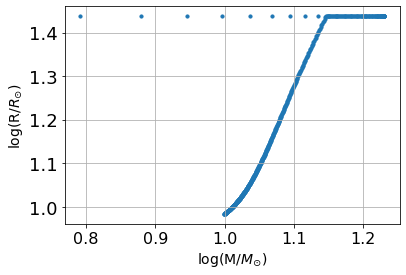

In [49]:
plt.scatter(mass_R, radius_R, s = 10)
# plt.xlim(-0.5,0.5)
# plt.ylim(-0.5,0.5)
plt.xlabel("log(M/$M_{\odot}$)", fontsize = '14')
plt.ylabel("log(R/$R_{\odot}$)", fontsize = '14')
# plt.xscale('log')
# plt.yscale('log')
# ax = plt.gca()  # Get the current axis
# ax.xaxis.set_minor_locator(MultipleLocator(1))
# ax.tick_params(which='minor', length=4, color='r')
plt.xticks(fontsize=16)
plt.yticks(fontsize=18)
plt.grid()
plt.show()